<a href="http://landlab.github.io"><img style="float: left"
src="https://raw.githubusercontent.com/landlab/tutorials/release/landlab_header.png"></a>

# Animate Landlab output
<hr>

<p><small>How to use IPython notebooks:
<a href="https://github.com/landlab/tutorials/blob/release/README.md">https://github.com/landlab/tutorials/blob/release/README.md</a></small></p>

<p><small>More Landlab tutorials:
<a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small></p>

<hr>

## Introduction
This tutorial presents a workflow to animate model output. The workflow is presented in two phases of a model.

This workflow requires software that might not be installed on your computer. The required software is open-source and freely available for Linux, MacOS, and Windows.
* In Phase 1, a mp4 video format is produced using FFMpeg that can be downloaded at [https://www.ffmpeg.org/download.html](https://www.ffmpeg.org/download.html).
* In Phase 2, a gif video format is produced using ImageMagick that can be downloaded at [https://www.imagemagick.org/script/download.php](https://www.imagemagick.org/script/download.php).

This software can also be installed using some package managers.

## Prepare the model for both phases

#### Import the modules called in this tutorial.

In [1]:
from landlab import RasterModelGrid
from landlab.components import FastscapeEroder, FlowRouter
from landlab.plot import channel_profile, imshow_grid
import matplotlib.animation as animation
import matplotlib.pylab as plt
import numpy as np

#### Set the graphics backend.

In [2]:
%matplotlib qt

#### Create a grid, set boundary conditions, and initialize components.

In [3]:
mg = RasterModelGrid((40, 40), 100)
z = mg.add_zeros('node','topographic__elevation')
z += np.random.rand(z.size)

outlet_id = int(mg.number_of_node_columns * 0.5)
mg.set_watershed_boundary_condition_outlet_id(outlet_id, z)
mg.at_node['topographic__elevation'][outlet_id] = 0

fr = FlowRouter(mg)
sp = FastscapeEroder(mg, K_sp=3e-5, m_sp=0.5, n_sp=1)

#### Set model time and uplift parameters.

In [4]:
simulation_duration = 1e6
dt = 1000
n_timesteps = int(simulation_duration // dt) + 1
timesteps = np.linspace(0, simulation_duration, n_timesteps,
                        endpoint=True)

uplift_rate = 0.001
uplift_per_timestep = uplift_rate * dt

## Phase 1: Animate elevation change using imshow_grid
#### Animate simulated topography as it tends toward steady state.

Before model timesteps are run, we prepare the animation:
* Create a matplotlib figure.
* Instantiate an animation writer using the matplotlib module, `animation`.
* Use `FFMpegWriter` to create a mp4 movie.
* Set up to animate 6 frames per second (fps).
* Prepare the animation writer with the method, `setup`.
* Set the output movie file name to 'first_phase.mp4'.

In [5]:
fig = plt.figure()
writer = animation.FFMpegWriter(fps=6)
writer.setup(fig, 'first_phase.mp4')

#### Capture the figure to animate at timesteps.

The method, `writer.grab_frame` captures the state of `fig` at designated timesteps. 

In [6]:
for t in timesteps:

    # Capture an animation frame every 50,000 years.
    if t % 5e4 == 0:
        imshow_grid(mg, z, colorbar_label='elevation (m)')
        plt.title('{:.0f} kiloyears'.format(t * 1e-3)) 

        writer.grab_frame()

        # Clear the figure so that it is ready for the next
        # animation timestep. Alternatively, the elements of
        # some plot types can be updated.
        plt.clf()

    # Uplift and erode.
    z[mg.core_nodes] += uplift_per_timestep
    fr.run_one_step()
    sp.run_one_step(dt)

#### Finish the animation.

The method, `writer.finish` completes the processing of the movie and saves then it.

In [7]:
writer.finish()

This code loads the saved mp4 and presents it in a browser in an IPython session.

In [8]:
from IPython.display import HTML

HTML("""<div align="middle"> <video width="80%" controls loop>
     <source src="first_phase.mp4" type="video/mp4"> </video></div>""")

## Phase 2: Animate multiple visualizations of elevation change over time

In the second model phase, we will create an animation similar to the one above, although with the following differences:
* The animation file format will be `gif`.
* The figure will have two subplots.
* One of the subplots will be updated rather than recreating the plot from scratch for each frame.
* The animation frame rate (fps) will be lower.

#### Increase uplift rate prior to running the second phase of the model.

In [9]:
increased_uplift_per_timestep = 10 * uplift_per_timestep

#### Set up a figure with two subplots.

Here we layout the figure with a left and right subplot.
* The left subplot will be an animation of the grid similar to what we created above. We will recreate the image of this subplot for each animation frame.
* The right subplot will be a line plot of the mean elevation over time. We will layout the subplot elements (labels, limits) before running the model, and then extend the plot line at each animation frame.

`axes[0]` and `axes[1]` refer to the left and right subplot, respectively.

In [10]:
fig2, axes = plt.subplots(1, 2, figsize=(9, 3))    
fig2.subplots_adjust(top=0.85, bottom=0.25, wspace=0.4)

# Layout right subplot.
time = 0
line, = axes[1].plot(time, z.mean(), 'k')

axes[1].set_title('mean elevation over time')
axes[1].set_xlim([0, 1000])
axes[1].set_ylim([0, 1000])
axes[1].set_xlabel('time (kyr)')
axes[1].set_ylabel('elevation (m)')

Text(0, 0.5, 'elevation (m)')

#### Set up a movie file.

A gif formatted movie is created in this model phase using the software, ImageMagick.

In [11]:
writer = animation.ImageMagickWriter(fps=2)
writer.setup(fig2, 'second_phase.gif')

#### Run the second phase of the model.

The simulation is ran for another 1,000,000 years. Animation frames are grabbed every 50,000 years.

In [12]:
for t in timesteps:
    
    if t % 5e4 == 0:
        # Get an animation frame.
        
        fig2.suptitle('{:.0f} kiloyears'.format(t * 1e-3)) 
        
        # Plot the left subplot.
        fig2.sca(axes[0])
        axes[0].set_title('topography')
        imshow_grid(mg, z, colorbar_label='elevation (m)')
        colorbar = plt.gci().colorbar
            
        # Update the right subplot.
        line.set_xdata(np.append(line.get_xdata(), t * 1e-3))
        line.set_ydata(np.append(line.get_ydata(), z.mean()))
        plt.draw()
            
        writer.grab_frame()

        # Reset the figure for the next animation timestep.
        plt.cla()
        colorbar.remove()

    # Uplift and erode.
    z[mg.core_nodes] += increased_uplift_per_timestep
    fr.run_one_step()
    sp.run_one_step(dt)
    
writer.finish()

This code loads the saved gif and presents it in a browser in an IPython session.

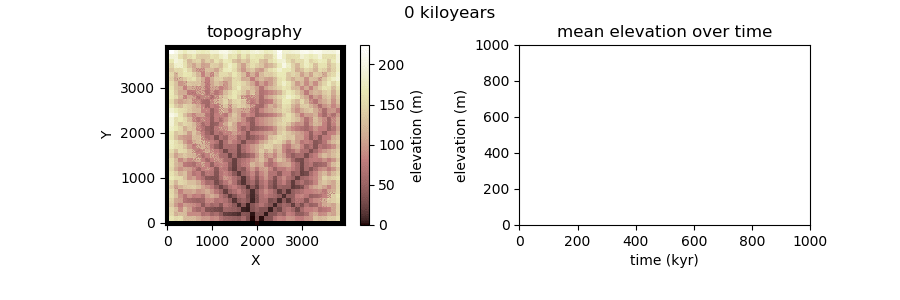

In [13]:
from IPython.display import Image

Image(filename='second_phase.gif') 

### Click here for more <a href="https://github.com/landlab/landlab/wiki/Tutorials">Landlab tutorials</a>